In [1]:
#Setup
import numpy as np
from numpy.testing import assert_almost_equal
import scipy.integrate as integrate
from scipy.stats import norm
import matplotlib.pyplot as plt 


## Part 0 - Setup

In [2]:
### Constants
sigma1 = 0.11
sigma2 = 0.13
T = 1.7
mu = 0.13
r = 0.01
S0 = 149
time_break = 0.3
K = 188
KH = S0
n_sims = 5_000
n_steps = int(T * 365) #Assume time in years, this is daily time-steps

In [3]:
### Helper Functions

### Time-varying vol

def time_varying_vol(t):
    if t > time_break:
        return sigma1 + sigma2 * (t - time_break)/(T - time_break)
    return sigma1

assert_almost_equal(np.array([time_varying_vol(0.2), time_varying_vol(0.4), time_varying_vol(0.5), time_varying_vol(T)]) ,
                    np.array([sigma1, 0.11928571428, 0.128571429, sigma1 + sigma2]))

def integrate_vol(start_time = 0, end_time = T):
    squared_vol = lambda x: time_varying_vol(x) ** 2
    result = integrate.quad(squared_vol, start_time, end_time)
    return result[0]

assert_almost_equal(np.array([integrate_vol(end_time = time_break), integrate_vol(0, 1), integrate_vol(start_time = 0)]),
                    np.array([time_break * sigma1 ** 2, 0.018090833333, 0.0484766666]))

### Black-Scholes

def get_d1_and_d2(S, t, K, T, r, sigma):
    tau = T - t
    d1 = 1/(sigma * np.sqrt(tau)) * (np.log(S/K) + (r + sigma ** 2 / 2) * tau)    
    d2 = d1 - sigma * np.sqrt(tau)
    return d1, d2


def black_scholes_call_price(S, t, K, T, r,sigma):
    d1, d2 = get_d1_and_d2(S, t, K, T, r, sigma)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def black_scholes_put_price(S,t, K,T,r,sigma):
    d1, d2 = get_d1_and_d2(S, t, K, T, r, sigma)
    return  K * np.exp(-r * T) * norm.cdf( -d2) - S * norm.cdf(-d1) 

def black_scholes_call_delta(S, t, K, T, r,sigma):
    d1, d2 = get_d1_and_d2(S, t, K, T, r, sigma)
    return norm.cdf(d1)

def black_scholes_put_delta(S, t, K, T, r,sigma):
    d1, d2 = get_d1_and_d2(S, t, K, T, r, sigma)
    return -1 * norm.cdf(-1 * d1)

def black_scholes_gamma(S, t, K, T, r,sigma):
    #same for a call and put
    d1, d2 = get_d1_and_d2(S, t, K, T, r, sigma)
    return norm.pdf(d1)/(S * sigma * np.sqrt(T - t))


assert_almost_equal(black_scholes_call_price(100,0,  100, 1, 0.01, 0.2), 8.43332, decimal = 5)
assert_almost_equal(black_scholes_call_delta(100,0, 100, 1, 0.01, 0.2), 0.55962, decimal = 5)
assert_almost_equal(black_scholes_gamma(100,0, 100, 1, 0.01, 0.2), 0.01972, decimal = 5)
assert_almost_equal(black_scholes_put_price(100,0, 100, 1, 0.01, 0.2), 7.43831, decimal = 5)
assert_almost_equal(black_scholes_put_delta(100,0, 100, 1, 0.01, 0.2), -0.44038, decimal = 5)
assert_almost_equal(black_scholes_gamma(100,0, 100, 1, 0.01, 0.2), 0.01972, decimal = 5)


## Q1 - Delta Hedging

In [6]:
def simulate_gbm(S0, mu, T, n_sims, n_steps):
    
    rng = np.random.default_rng(seed = 42)
    paths = np.zeros([n_sims, n_steps + 1])
    dt = T / n_steps
    paths[:, 0] = S0

    times = np.linspace(0, T, n_steps + 1)

    epsilon = rng.normal(size = [n_sims, n_steps])
    
    for i in range(0, n_steps):
        #Euler-Maruyama Scheme
        paths[:, i + 1] = paths[:, i] + paths[:, i] * mu * dt + paths[:, i] * time_varying_vol(times[i]) * np.sqrt(dt) * epsilon[:, i]
                                               
    return paths, times

def simulate_delta_varying_vol(S0, K, T, r, mu, n_sims, n_steps):
    
    int_vol = np.sqrt(1 / T * integrate_vol(end_time = T))
    paths, times = simulate_gbm(S0, mu, T, n_sims, n_steps)
    V = black_scholes_call_price(S0, 0, K, T, r, int_vol)

    portfolio = np.zeros(paths.shape)
    portfolio[:, 0] = V
    t = times[0]
    dt = T / n_steps

    for i in range(0, len(times) - 1):
        t = times[i]
    
        S_at_t = paths[:, i] 
        S_at_t_plus_dt = paths[:, i+1]

        vol_t = np.sqrt(1 / (T - t) * integrate_vol(start_time = t, end_time = T))
        delta_t = black_scholes_call_delta(S_at_t, t, K, T, r, vol_t)

        bank_at_t = portfolio[:, i] - delta_t * S_at_t 
        
        bank_at_t_plus_dt = bank_at_t * np.exp(dt * r)
        new_stock_value = delta_t * S_at_t_plus_dt

        portfolio[:, i + 1] = bank_at_t_plus_dt + new_stock_value

    S_T = paths[:, -1]
    
    final_portfolio = portfolio[:, -1]
    error = final_portfolio - np.maximum(S_T - K, 0)
    return error, V



In [7]:
error, price = simulate_delta_varying_vol(S0, K, T, r, mu, n_sims,  n_steps)


In [8]:
error_test, price_test = simulate_delta_varying_vol(S0, K, 0.3, r, mu, n_sims,  n_steps)
assert_almost_equal(price_test, black_scholes_call_price(S0, 0, K, 0.3, r, sigma1))

(array([  1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   2.,   1.,   3.,
          0.,   2.,   2.,   4.,   5.,   8.,  16.,  15.,  28.,  42.,  49.,
         71.,  97., 144., 228., 306., 401., 687., 839., 614., 423., 303.,
        203., 140.,  97.,  64.,  62.,  45.,  26.,  19.,   7.,  15.,  12.,
          6.,   7.,   2.,   1.,   1.,   1.]),
 array([-4.81681751, -4.65285126, -4.48888502, -4.32491877, -4.16095253,
        -3.99698628, -3.83302004, -3.66905379, -3.50508754, -3.3411213 ,
        -3.17715505, -3.01318881, -2.84922256, -2.68525632, -2.52129007,
        -2.35732383, -2.19335758, -2.02939134, -1.86542509, -1.70145884,
        -1.5374926 , -1.37352635, -1.20956011, -1.04559386, -0.88162762,
        -0.71766137, -0.55369513, -0.38972888, -0.22576264, -0.06179639,
         0.10216986,  0.2661361 ,  0.43010235,  0.59406859,  0.75803484,
         0.92200108,  1.08596733,  1.24993357,  1.41389982,  1.57786606,
         1.74183231,  1.90579856,  2.0697648 ,  2.23373105,  2.39769729,
 

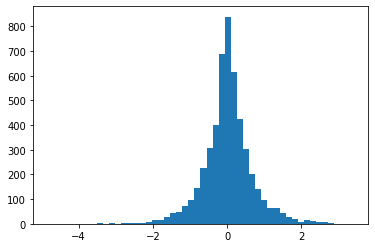

In [9]:
plt.hist(error, bins = 50)

(array([   3.,    2.,    5.,    8.,   18.,   36.,   92.,  197.,  421.,
         898., 1729.,  857.,  373.,  191.,   81.,   49.,   22.,    9.,
           4.,    5.]),
 array([-0.40357168, -0.36501452, -0.32645735, -0.28790018, -0.24934301,
        -0.21078584, -0.17222867, -0.1336715 , -0.09511433, -0.05655717,
        -0.018     ,  0.02055717,  0.05911434,  0.09767151,  0.13622868,
         0.17478585,  0.21334301,  0.25190018,  0.29045735,  0.32901452,
         0.36757169]),
 <BarContainer object of 20 artists>)

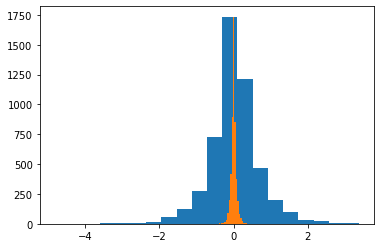

In [10]:
error1, price1 = simulate_delta_varying_vol(S0, K, T, r, mu, n_sims, n_steps)
error2, price1 = simulate_delta_varying_vol(S0, K, T, r, mu, n_sims, 100 * n_steps)

plt.hist(error1,bins = 20)
plt.hist(error2, bins = 20)


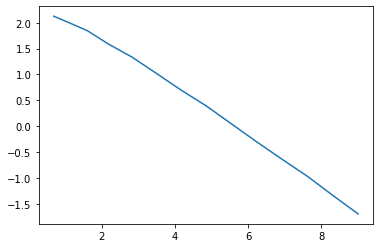

In [11]:
n_points = 14
n_steps_rme_testing = np.zeros(n_points)
rms_error = np.zeros(n_points)
for i in range(0, n_points):
    n_steps_rme_testing[i] = 2 ** i + 1
    error, price = simulate_delta_varying_vol(S0, K, T, r,  mu, n_sims, int(n_steps_rme_testing[i]))
    rms_error[i] = np.sqrt(np.mean(error ** 2))

ax = plt.gca()
ax.plot(np.log(n_steps_rme_testing), np.log(rms_error))

